In [1]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Function Definitions:

In [2]:
def process_file(fn_path, list_cols):
  df_temp = pd.read_csv(fn_path, sep='\t')
  df_temp = df_temp[list_cols]
  return df_temp


def select_most_significant(row):
    # Check for NaN values and select the data accordingly
    if pd.isna(row['neg|fdr']) and pd.isna(row['pos|fdr']):
        return None, None, None  # Both are NaN
    elif pd.isna(row['neg|fdr']):
        return row['pos|lfc'], row['pos|fdr'], 'Positive'
    elif pd.isna(row['pos|fdr']):
        return row['neg|lfc'], row['neg|fdr'], 'Negative'
    else:
        # Both values are present, choose the one with the lower p-value
        if row['neg|fdr'] < row['pos|fdr']:
            return row['neg|lfc'], row['neg|fdr'], 'Negative'
        else:
            return row['pos|lfc'], row['pos|fdr'], 'Positive'


Loading datasets from Google Drive:

In [3]:
path_data = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/data"
path_data_raw = os.path.join(path_data, 'Stagewise_Mageck')
fn_meta = os.path.join(path_data, 'Stagewise_Mageck.xlsx') # this is the meta-data file.

df_meta = pd.read_excel(fn_meta)
col_fn = 'Comparison file name'
col_short = 'Code'
dict_fn_to_id = dict(zip(df_meta[col_fn], df_meta[col_short]))

# Collating all TnSeq screens, across all stages, into a single master dataframe:

In [4]:
col_lfc_neg = 'neg|lfc'
col_pval_neg = 'neg|fdr'
col_lfc_pos = 'pos|lfc'
col_pval_pos = 'pos|fdr'
col_gene = 'id'
list_cols = [col_gene, col_lfc_neg, col_pval_neg, col_lfc_pos, col_pval_pos]

combined_df = pd.DataFrame()

# Loop through directories, subdirectories, and files
for dirpath, dirnames, filenames in os.walk(path_data_raw):
  for filename in tqdm(filenames, desc="Processing files"):
    # Construct the full path to the file
    full_file_path = os.path.join(dirpath, filename)
    file_id = dict_fn_to_id[filename.split('.txt')[0]]

    # Process neg. and pos. data
    df = process_file(full_file_path, list_cols)
    df['Code'] = file_id  # Add the screen/file_id column

    # Combine the data
    combined_df = pd.concat([combined_df, df])


Processing files: 0it [00:00, ?it/s]
Processing files: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Select the most significant p-value (for neg. vs. pos. MAGECK data)


In [5]:
# Keep that as the *main* data values
# Apply the function to each row in the DataFrame
combined_df['lfc'], combined_df['fdr'], combined_df['effect'] = zip(*combined_df.apply(select_most_significant, axis=1))
combined_df.shape

(236615, 9)

Add information about screen stage:


In [6]:
df_meta_stage = df_meta[['Code', 'Which stage']]
combined_df = pd.merge(combined_df, df_meta_stage, on = 'Code')
combined_df.head(2)

,id,neg|lfc,neg|fdr,pos|lfc,pos|fdr,Code,lfc,fdr,effect,Which stage
0,RVBD3859c:gltB,-2.2731,0.000003,0.0,1.0,M.II.5G.10%O2vsDep.Yes,-2.2731,0.000003,Negative,2nd
1,RVBD3596c:clpC1,-3.7115,0.000003,0.0,1.0,M.II.5G.10%O2vsDep.Yes,-3.7115,0.000003,Negative,2nd


In [7]:
unique_codes_per_stage = combined_df.groupby('Which stage')['Code'].nunique()

print(unique_codes_per_stage)

Which stage
1st    12
2nd    16
3rd    20
4th    12
Name: Code, dtype: int64


Discard problematic screens (see EDA_MAGECK.ipynb)

In [8]:
list_scr_discard = ['M.III.10G.P18hrsD1d.No', 'M.III.10G.D1dvsDep.No', 'M.III.10G.D1d10%O2.No']
stages_for_codes = combined_df[combined_df['Code'].isin(list_scr_discard)]
unique_code_stage = stages_for_codes[['Code', 'Which stage']].drop_duplicates()
print(unique_code_stage)

                          Code Which stage
120200   M.III.10G.D1d10%O2.No         3rd
136242   M.III.10G.D1dvsDep.No         3rd
192307  M.III.10G.P18hrsD1d.No         4th


In [9]:
df_discard = combined_df[combined_df.Code.isin(list_scr_discard)].copy()
df_filter = combined_df[~combined_df.Code.isin(list_scr_discard)].copy()

# we are discarding the following number of genes from these 3 screns
print(df_filter.shape[0], combined_df.shape[0])
df_discard.Code.value_counts()

228304 236615


Code
M.III.10G.D1dvsDep.No     4013
M.III.10G.D1d10%O2.No     4010
M.III.10G.P18hrsD1d.No     288
Name: count, dtype: int64

In [10]:
unique_codes_per_stage = df_filter.groupby('Which stage')['Code'].nunique()

print(unique_codes_per_stage)

Which stage
1st    12
2nd    16
3rd    18
4th    11
Name: Code, dtype: int64


### What are the different comparisons in each stage?


In [11]:
comps_1st = df_filter[df_filter["Which stage"]=='1st'].Code.unique().tolist()
comps_1st.sort()
comps_1st

['M.I.10G.0.2%O2vsDep.No',
 'M.I.10G.0.2%O2vsDep.Yes',
 'M.I.20G.0.2%O2vsDep.No',
 'M.I.20G.0.2%O2vsDep.Yes',
 'M.I.5G.0.2%O2vsDep.No',
 'M.I.5G.0.2%O2vsDep.Yes',
 'M.III.10G.0.2%O2vsDep.No',
 'M.III.10G.0.2%O2vsDep.Yes',
 'M.III.20G.0.2%O2vsDep.No',
 'M.III.20G.0.2%O2vsDep.Yes',
 'M.III.5G.0.2%O2vsDep.No',
 'M.III.5G.0.2%O2vsDep.Yes']

In [12]:
[comp for comp in comps_1st if 'Dep.Yes' in comp]


['M.I.10G.0.2%O2vsDep.Yes',
 'M.I.20G.0.2%O2vsDep.Yes',
 'M.I.5G.0.2%O2vsDep.Yes',
 'M.III.10G.0.2%O2vsDep.Yes',
 'M.III.20G.0.2%O2vsDep.Yes',
 'M.III.5G.0.2%O2vsDep.Yes']

In [13]:
[comp for comp in comps_1st if 'Dep.No' in comp]



['M.I.10G.0.2%O2vsDep.No',
 'M.I.20G.0.2%O2vsDep.No',
 'M.I.5G.0.2%O2vsDep.No',
 'M.III.10G.0.2%O2vsDep.No',
 'M.III.20G.0.2%O2vsDep.No',
 'M.III.5G.0.2%O2vsDep.No']

# For each stage, count the number of times each gene is essential:


In [14]:
list_stages = df_filter['Which stage'].unique()
list_stages.sort()
list_stages


array(['1st', '2nd', '3rd', '4th'], dtype=object)

In [15]:
# Loop through all the stages and merge the resulting dataframes
# to have a single dataframe with counts for each stage for every gene.

# Assuming 'df_filter' is your original DataFrame that contains all the genes and stages
# and 'list_stages' is a list of all the stages

# Define thresholds
lfc_threshold = -1
fdr_threshold = 0.05

# Initialize an empty DataFrame to collect counts for each stage
all_stages_counts_df = None

# Loop through each stage
for stage in tqdm(list_stages):
    df_stage = df_filter[df_filter['Which stage'] == stage].copy()

    # Find rows that pass both thresholds
    df_th = df_stage[(df_stage['lfc'] <= lfc_threshold) & (df_stage['fdr'] <= fdr_threshold)]

    # Get the counts of genes that passed the threshold
    threshold_counts = df_th['id'].value_counts()

    # Convert the Series to a DataFrame
    threshold_counts_df = threshold_counts.reset_index()
    threshold_counts_df.columns = ['id', 'Counts']

    # Create a DataFrame from the original gene list with all genes set to 0 counts
    all_genes_df = pd.DataFrame({'id': df_filter['id'].unique()})

    # Merge the count data back onto the all_genes_df DataFrame
    merged_df = all_genes_df.merge(threshold_counts_df, on='id', how='left')

    # Replace NaN values with 0 for genes that did not pass the threshold
    col_stage_counts = 'Counts_' + stage
    merged_df[col_stage_counts] = merged_df['Counts'].fillna(0).astype(int)

    # Drop the temporary 'Counts' column as it's no longer needed
    merged_df.drop('Counts', axis=1, inplace=True)

    # Merge with the main DataFrame to accumulate the results
    if all_stages_counts_df is None:
        all_stages_counts_df = merged_df
    else:
        all_stages_counts_df = all_stages_counts_df.merge(merged_df, on='id', how='outer')

# Calculate the total counts across all stages
all_stages_counts_df['Total_Counts'] = all_stages_counts_df.filter(like='Counts_').sum(axis=1)
all_stages_counts_df.sort_values(by = ['Total_Counts'], ascending=False, inplace=True)

all_stages_counts_df.reset_index(drop=True, inplace=True)
# Display the final DataFrame
all_stages_counts_df.head(2)


100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


,id,Counts_1st,Counts_2nd,Counts_3rd,Counts_4th,Total_Counts
0,RVBD3596c:clpC1,9,8,11,8,36
1,RVBD1828:RVBD1828,10,5,13,6,34


In [16]:
all_stages_counts_df[all_stages_counts_df.Total_Counts==0].shape[0]

1252

In [17]:
all_stages_counts_df[all_stages_counts_df.Total_Counts!=0].shape[0]

2763

## Save files to output:

In [18]:
path_data

'/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/data'

In [19]:
fn_counts_out = os.path.join(path_data, 'counts_all_stages_MAGECK.xlsx')
all_stages_counts_df.to_excel(fn_counts_out, index=False)

In [20]:
fn_lfc_fdr_data = os.path.join(path_data, 'lfc_fdr_data_MAGECK.tsv')
df_filter.to_csv(fn_lfc_fdr_data, index=False, sep='\t')

# Visualize averaged volcano plots with bubble size scaling with counts:


This is a test for a single stage:

In [21]:
# List of genes to highlight
genes_to_highlight = ['clpC1', 'clpP1', 'clpP2', 'groEL2', 'prcA', 'prcB', 'dnaJ2', 'otsA', 'otsB2', 'devR']
genes_top = [g.split(':')[1] for g in all_stages_counts_df.head(10).id.tolist()]

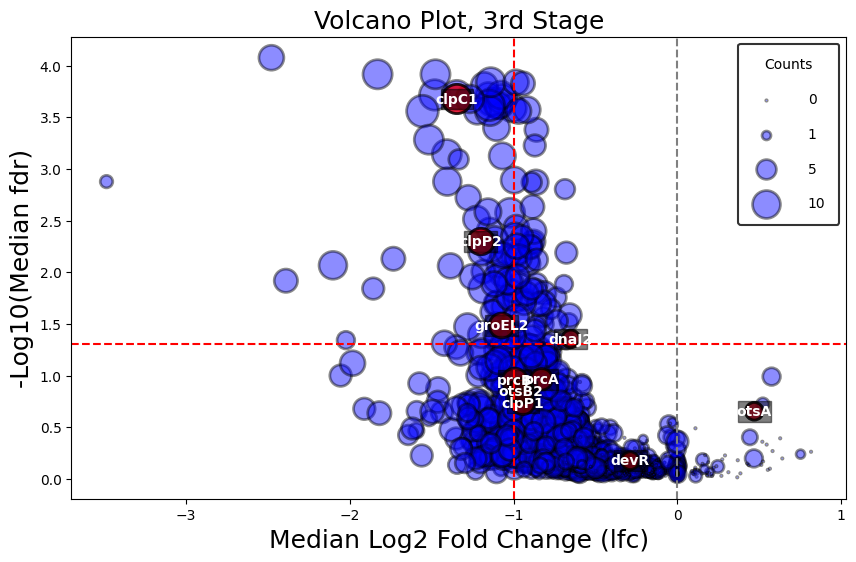

In [22]:
stage = '3rd'
df_stage = df_filter[df_filter['Which stage'] == stage].copy()
df_stage = df_stage[['id', 'Code', 'lfc', 'fdr', 'Which stage']].copy()
df_stage.reset_index(inplace = True, drop=True)

# Group by 'id' and calculate median 'lfc' and 'fdr'
median_df_stage = df_stage.groupby('id').agg({'lfc': 'median', 'fdr': 'median'}).reset_index()
# Convert fdr to -log10 scale for better visualization
median_df_stage['-log10(fdr)'] = -np.log10(median_df_stage['fdr'])

# Merge to include 'Total_Counts' for bubble size scaling
counts_col = 'Counts_'+stage
merged_df = pd.merge(median_df_stage, all_stages_counts_df[['id', counts_col]], on='id', how = 'inner')

# Assuming this is the scaling factor you're using for bubble sizes
base_bubble_size = 1
scaling_factor = 40

# Calculate the sizes
merged_df['bubble_size'] = base_bubble_size + (merged_df[counts_col] * scaling_factor)

fn_median_df = os.path.join(path_data, 'median_df_stage_'+stage+'.xlsx')
merged_df.to_excel(fn_median_df, index=False)

# Create the volcano plot with bubble size scaling
plt.figure(figsize=(10, 6))

# Filter merged_df to get only the rows where the part of 'id' after the colon matches the genes of interest
highlighted_genes_df = merged_df[merged_df['id'].str.split(':').str[-1].isin(genes_to_highlight)]
# highlighted_genes_df = merged_df[merged_df['id'].str.split(':').str[-1].isin(genes_top)]

plt.scatter(merged_df['lfc'], merged_df['-log10(fdr)'],
            s = merged_df['bubble_size'],
            color='blue', alpha=0.45, edgecolor='k', linewidth=2)

# # Overlay the points for the highlighted genes in a different color
plt.scatter(highlighted_genes_df['lfc'], highlighted_genes_df['-log10(fdr)'],
            s = highlighted_genes_df['bubble_size'],
            color='red', alpha=0.75, edgecolor='k', linewidth=2)

# Annotate the highlighted points with gene names
for index, row in highlighted_genes_df.iterrows():
    gene_name = row['id'].split(':')[1]  # Extracting gene name from the 'id' column
    x = row['lfc']
    y = row['-log10(fdr)']
    plt.text(x, y, gene_name,
             fontsize=10, weight='bold', color='white', ha='center', va='center')

    # Add a text background for readability
    p = patches.Rectangle((x-0.1, y-0.1), 0.2, 0.2, transform=plt.gca().transData, color='black', alpha=0.5)
    plt.gca().add_patch(p)

plt.axvline(x=0, color='grey', linestyle='--')
plt.axvline(x=-1, color='red', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')

plt.title(f'Volcano Plot, {stage} Stage', fontsize = 18)
plt.xlabel('Median Log2 Fold Change (lfc)', fontsize = 18)
yl = plt.ylabel('-Log10(Median fdr)', fontsize = 18)

# Create custom legend for bubble sizes
legend_bubble_sizes = base_bubble_size + np.array([0,1,5,10])*scaling_factor
for size in legend_bubble_sizes:
    plt.scatter([], [], s=size, label=str(size//40),
                color='blue',  alpha=0.45, edgecolor='k', linewidth=2)
# Add the legend to the plot with a black edge around the legend box
lgd = plt.legend(scatterpoints=1, frameon=True, labelspacing=1.5, title='Counts', borderpad=1, handletextpad=2)

lgd.get_frame().set_edgecolor('k')  # Set legend frame edge color to black
lgd.get_frame().set_linewidth(1.5)  # Set legend frame line width


## For each stage, plot a modified "bubble" volcano plot, which shows:
- median log2-FC and fdr values
- size of bubble for each gene scales with the per-stage metric of essentiality counts.

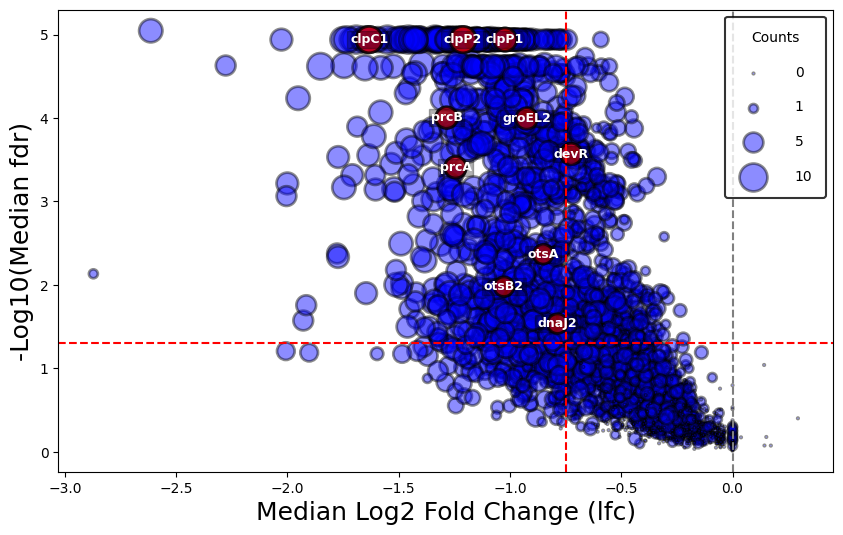

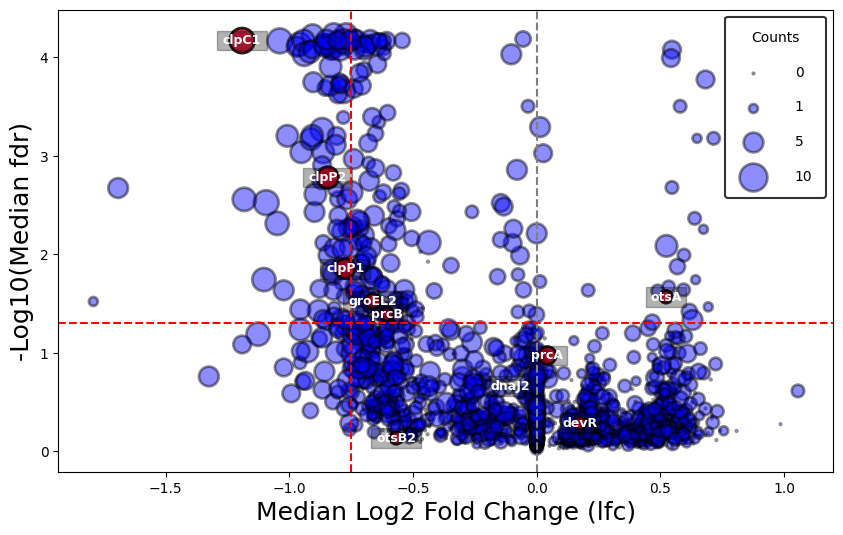

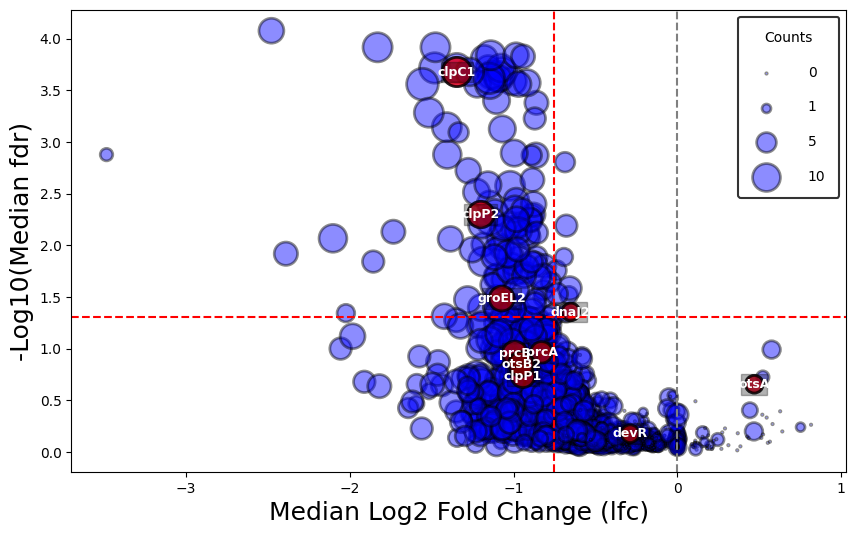

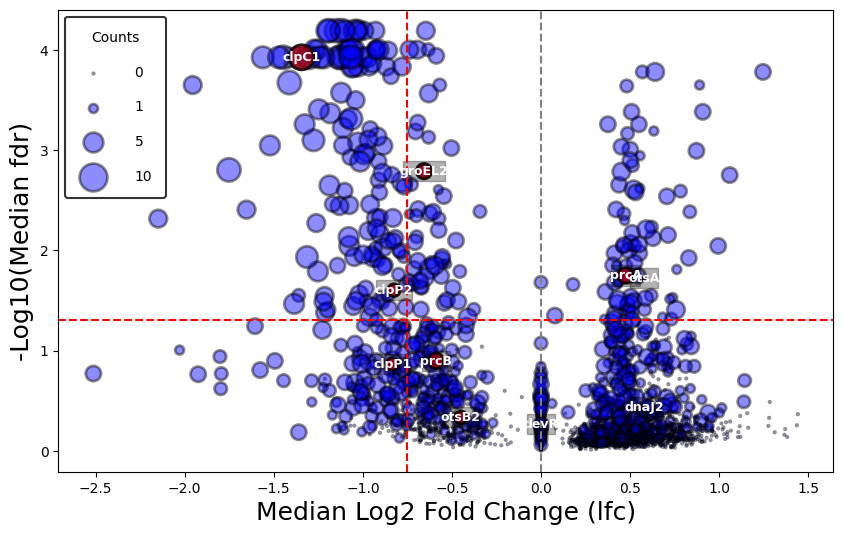

In [23]:
for stage in list_stages:
  # stage = '4th'
  df_stage = df_filter[df_filter['Which stage'] == stage].copy()
  df_stage = df_stage[['id', 'Code', 'lfc', 'fdr', 'Which stage']].copy()
  df_stage.reset_index(inplace = True, drop=True)

  # Group by 'id' and calculate median 'lfc' and 'fdr'
  median_df_stage = df_stage.groupby('id').agg({'lfc': 'median', 'fdr': 'median'}).reset_index()
  # Convert fdr to -log10 scale for better visualization
  median_df_stage['-log10(fdr)'] = -np.log10(median_df_stage['fdr'])

  # Merge to include 'Total_Counts' for bubble size scaling
  counts_col = 'Counts_'+stage
  merged_df = pd.merge(median_df_stage, all_stages_counts_df[['id', counts_col]], on='id', how = 'inner')

  # Save per-stage averaged (median lfc and fdr) dataframes including counts.
  fn_median_df = os.path.join(path_data, 'median_df_stage_'+stage+'.xlsx')
  merged_df.to_excel(fn_median_df, index=False)

  # Create the volcano plot with bubble size scaling
  base_bubble_size = 1
  scaling_factor = 40
  plt.figure(figsize=(10, 6))

  # Filter merged_df to get only the rows where the part of 'id' after the colon matches the genes of interest
  highlighted_genes_df = merged_df[merged_df['id'].str.split(':').str[-1].isin(genes_to_highlight)]
  # highlighted_genes_df = merged_df[merged_df['id'].str.split(':').str[-1].isin(genes_top)]

  plt.scatter(merged_df['lfc'], merged_df['-log10(fdr)'],
              s = base_bubble_size + merged_df[counts_col]*scaling_factor,
              color='blue', alpha=0.45, edgecolor='k', linewidth=2)

  # Overlay the points for the highlighted genes in a different color
  plt.scatter(highlighted_genes_df['lfc'], highlighted_genes_df['-log10(fdr)'],
              s = base_bubble_size + highlighted_genes_df[counts_col]*scaling_factor,
              color='red', alpha=0.75, edgecolor='k', linewidth=2)

  # Annotate the highlighted points with gene names
  for index, row in highlighted_genes_df.iterrows():
      gene_name = row['id'].split(':')[1]  # Extracting gene name from the 'id' column
      x = row['lfc']
      y = row['-log10(fdr)']
      # Calculate text width and height for the background patch
      text_width = len(gene_name) * 0.04  # Adjust multiplier as needed for your font size and figure dpi
      text_height = 0.2  # Adjust as needed for your font size and figure dpi
      # Add a text background for readability
      p = patches.Rectangle((x - text_width / 2, y - text_height / 2), text_width, text_height,
                            transform=plt.gca().transData, color='black', alpha=0.3)
      # Annotate with gene names after adding the patch to ensure text is on top
      plt.text(x, y, gene_name, fontsize=9, weight='bold', color='white',
              ha='center', va='center', zorder=10)
      plt.gca().add_patch(p)

  plt.axvline(x=0, color='grey', linestyle='--')
  plt.axvline(x=-0.75, color='red', linestyle='--')
  plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')

  # plt.title(f'Volcano Plot, {stage} Stage', fontsize = 18)
  plt.xlabel('Median Log2 Fold Change (lfc)', fontsize = 18)
  plt.ylabel('-Log10(Median fdr)', fontsize = 18)

  # Create custom legend for bubble sizes
  legend_bubble_sizes = base_bubble_size + np.array([0,1,5,10])*scaling_factor
  for size in legend_bubble_sizes:
      plt.scatter([], [], s=size, label=str(size//40),
                  color='blue',  alpha=0.45, edgecolor='k', linewidth=2)
  # Add the legend to the plot with a black edge around the legend box
  lgd = plt.legend(scatterpoints=1, frameon=True, labelspacing=1.5, title='Counts', borderpad=1, handletextpad=2)

  lgd.get_frame().set_edgecolor('k')  # Set legend frame edge color to black
  lgd.get_frame().set_linewidth(1.5)  # Set legend frame line width

  fn_path = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/figures/bubble_plots/"
  fn_fig = os.path.join(fn_path, stage+'_volcano_plot_ValidationSet.png')
  plt.savefig(fn_fig, dpi=300)

###Gene Essentiality in a Model Aerosol Fluid (MAF) Across Different Stages.

Volcano plots showing median log2 fold change (L2FC) on the x-axis against the negative log10 of the median FDR-adjusted p-value on the y-axis. The size of each point indicates the total number of essentiality counts—the number of times a gene is detected as conditionally essential across multiple comparisons within each stage. Highlighted genes (in red) correspond to [HELP PHRASING THIS: proteostasis pathway genes].


# Sliding window plots:

This next analysis measures what fraction of genes in the n-th ranked/percentile of those with highest conditional essentiality counts are "in vitro" essential (according to deJesus et al., Comprehensive Essentiality Analysis of the Mycobacterium tuberculosis Genome via Saturating Transposon Mutagenesis (2017))

In [24]:
# for standard lab conditions, we use the mBio calls.
# these essentiality calls and handily included in the MAGECK output files from Michael
# So we grab a random file and fetch it from there:
path_MGK = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/data/Stagewise_Mageck"
filename = 'result_1846_5Generation_PostMCFwithATc_vs_1845_5Generation_PostDepwithATc_alphamedian_control_control_lod20_10_31_2023.mageck.gene_summary.txt'
full_file_path = os.path.join(path_MGK, '1st_stage', filename)
df_mBio = pd.read_csv(full_file_path, sep = '\t')
df_mBio = df_mBio[['id', 'orf', 'name', 'essentiality', 'mbio Call']]
df_mBio.head(2)

,id,orf,name,essentiality,mbio Call
0,RVBD0006:gyrA,RVBD0006,gyrA,Essential,ES
1,RVBD1547:dnaE1,RVBD1547,dnaE1,Essential,ES


Rank genes according to their essentiality counts:


In [25]:
# Rank based on Average Counts and use Balance Score as a tiebreaker
all_stages_counts_df['Rank'] = all_stages_counts_df.sort_values(by=['Total_Counts'], ascending=[False]).index

# Display the DataFrame
all_stages_counts_df.sort_values(by='Rank', inplace=True)
all_stages_counts_df.head(5)

,id,Counts_1st,Counts_2nd,Counts_3rd,Counts_4th,Total_Counts,Rank
0,RVBD3596c:clpC1,9,8,11,8,36,0
2,RVBD0430:RVBD0430,10,7,10,7,34,1
1,RVBD1828:RVBD1828,10,5,13,6,34,2
3,RVBD2093c:tatC,7,7,11,7,32,3
4,RVBD0732:secY,10,6,9,7,32,4


In [26]:
df_rank_mbio = pd.merge(all_stages_counts_df, df_mBio, on = 'id')
df_rank_mbio.head(2)


,id,Counts_1st,Counts_2nd,Counts_3rd,Counts_4th,Total_Counts,Rank,orf,name,essentiality,mbio Call
0,RVBD3596c:clpC1,9,8,11,8,36,0,RVBD3596c,clpC1,Essential,ES
1,RVBD0430:RVBD0430,10,7,10,7,34,1,RVBD0430,RVBD0430,Essential,ES


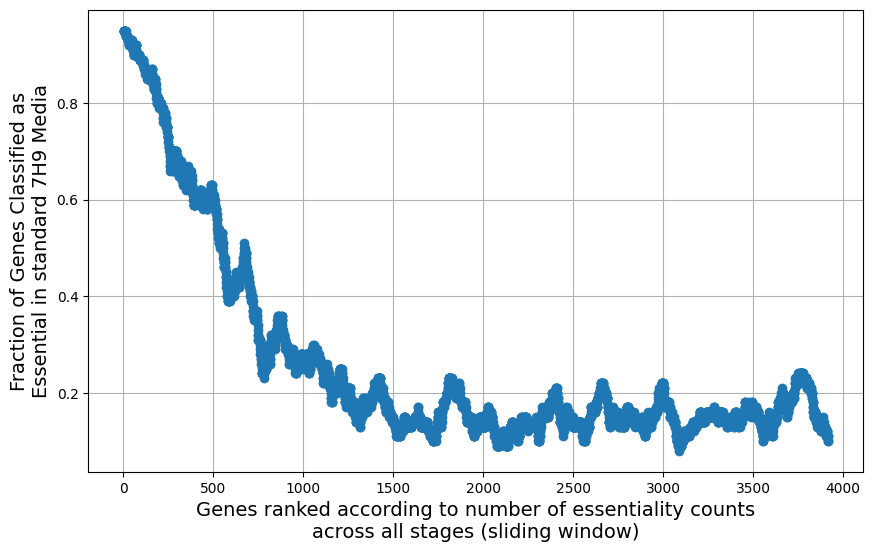

In [27]:
# Define the window size
window_size = 100

# Sliding window analysis
non_essential_fractions = []
essential_fractions = []

for start in range(len(df_rank_mbio) - window_size + 1):
    window = df_rank_mbio.iloc[start:start + window_size]
    non_essential_count = window[window['mbio Call'] == 'NE'].shape[0]
    non_essential_fraction = non_essential_count / window_size
    essential_fraction = 1 - non_essential_fraction
    non_essential_fractions.append(non_essential_fraction)
    essential_fractions.append(essential_fraction)


# Plot the results
plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(non_essential_fractions) + 1), non_essential_fractions, marker='o')
plt.plot(range(1, len(essential_fractions) + 1), essential_fractions, marker='o')

plt.xlabel('Genes ranked according to number of essentiality counts\nacross all stages (sliding window)', fontsize = 14)
plt.ylabel('Fraction of Genes Classified as\nEssential in standard 7H9 Media', fontsize = 14)
# plt.title('Sliding Window Analysis of fraction of mBio Non-Essential Genes')
plt.grid(True)

fn_path = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/figures/sliding_window_plots/"
fn_fig = os.path.join(fn_path, 'sliding_window.png')
plt.savefig(fn_fig, dpi=300)

### Variation in Essential Gene Frequency in MAF Relative to Standard (7H9) Conditions.

Mycobacterium tuberculosis (Mtb) genes were ranked according to their essentiality in a Model Aerosol Fluid (MAF) across all stages. At each rank, the plotted fraction (within a set of 100 consecutive genes) indicates the proportion previously categorized as essential in standard 7H9/10 media. The decrease in this proportion with descending MAF essentiality ranks suggests that genes deemed non-essential under standard in vitro conditions are individually making small fitness impacts, contributing cooperatively to survival in a host-like environment.


# How many conventionally non-essential genes had one or more essentiality counts in any stage?


In [28]:
df_rank_mbio['mbio Call'].value_counts()

mbio Call
NE           2934
ES            460
GA            303
GD            135
Uncertain      72
ESD            29
Name: count, dtype: int64

In [29]:
df_rank_mbio_NE = df_rank_mbio[df_rank_mbio['mbio Call'] == 'NE'].copy()
num_NE = df_rank_mbio_NE.shape[0]
num_one_or_more_counts_NE = df_rank_mbio_NE[df_rank_mbio_NE.Total_Counts>0].shape[0]

print(f'Number of conventionally non-essential genes: {num_NE}')
print(f'Number of these with at least one essentiality count: {num_one_or_more_counts_NE}')
num_one_or_more_counts_NE/num_NE

Number of conventionally non-essential genes: 2934
Number of these with at least one essentiality count: 1873


0.6383776414451261

# What proportion of the genome had any essentiality count, and of those, what proportion were conventionally essential and what proportion were conventionally nonessential?


Collectively, 69% of the 4014 genes had NOSC > 1 and 45% had NOSC > 3 in any of the stages (31%, 10% and 29% in stages 1-3 respectively). While some genes with low NOSC scores may represent false positives, these results suggest that a significant proportion of Mtb's genome contributes to its survival in this model of transmission.


In [31]:
genes_with_any_essentiality_counts = df_rank_mbio[df_rank_mbio.Total_Counts>0].shape[0]
total_genes = df_rank_mbio.shape[0]

print(f'Number of genes with any essentiality count: {genes_with_any_essentiality_counts}')
print(f'Number of total genes: {total_genes}')
print(f'Proportion of genome with any essentiality count: {genes_with_any_essentiality_counts/total_genes}')


Number of genes with any essentiality count: 2763
Number of total genes: 4015
Proportion of genome with any essentiality count: 0.6881693648816937


In [34]:
genes_with_3ormore_essentiality_counts = df_rank_mbio[df_rank_mbio.Total_Counts>=3].shape[0]
print(f'Number of genes with 3 or more essentiality count: {genes_with_3ormore_essentiality_counts}')
print(f'Proportion of genome: {genes_with_3ormore_essentiality_counts/total_genes}')


Number of genes with 3 or more essentiality count: 1806
Proportion of genome: 0.449813200498132


In [41]:
genes_with_3ormore_1st = df_rank_mbio[df_rank_mbio.Counts_1st>=3].shape[0]
print(f'Number of genes with 3 or more essentiality count in 1st Stage: {genes_with_3ormore_1st}')
print(f'Proportion of genome: {genes_with_3ormore_1st/total_genes*100:.2f}%')

genes_with_3ormore_2nd = df_rank_mbio[df_rank_mbio.Counts_2nd>=3].shape[0]
print(f'Number of genes with 3 or more essentiality count in 2nd Stage: {genes_with_3ormore_2nd}')
print(f'Proportion of genome: {genes_with_3ormore_2nd/total_genes*100:.2f}%')

genes_with_3ormore_3rd = df_rank_mbio[df_rank_mbio.Counts_3rd>=3].shape[0]
print(f'Number of genes with 3 or more essentiality count in 3rd Stage: {genes_with_3ormore_3rd}')
print(f'Proportion of genome: {genes_with_3ormore_3rd/total_genes*100:.2f}%')



Number of genes with 3 or more essentiality count in 1st Stage: 1240
Proportion of genome: 30.88%
Number of genes with 3 or more essentiality count in 2nd Stage: 402
Proportion of genome: 10.01%
Number of genes with 3 or more essentiality count in 3rd Stage: 1148
Proportion of genome: 28.59%


In [ ]:
num_ES = df_rank_mbio[ ( df_rank_mbio.Total_Counts>0 ) & ( df_rank_mbio['mbio Call'] == 'ES')].shape[0]
num_NE = df_rank_mbio[ ( df_rank_mbio.Total_Counts>0 ) & ( df_rank_mbio['mbio Call'] == 'NE')].shape[0]

print(f'Number of genes with any essentiality count that are essential: {num_ES}')
print(f'Number of genes with any essentiality count that are conventionally nonessential: {num_NE}')
print(f'Proportion of genes with any essentiality count that are essential: {num_ES/genes_with_any_essentiality_counts}')
print(f'Proportion of genes with any essentiality count that are essential: {num_NE/genes_with_any_essentiality_counts}')


Number of genes with any essentiality count that are essential: 457
Number of genes with any essentiality count that are conventionally nonessential: 1873
Proportion of genes with any essentiality count that are essential: 0.16539992761491132
Proportion of genes with any essentiality count that are essential: 0.6778863554107853


# Can you list the highest fold-change for each non-essential gene for any of its essentiality count(s) in any stage, and provide a histogram of that?


In [ ]:
import tqdm

In [ ]:
fdr_th = 0.05
gene_id = 'RVBD0583c:lpqN'
df_gene_id = df_filter[df_filter['id'] == gene_id].copy()
df_gene_id_sig = df_gene_id[df_gene_id.fdr<=fdr_th].copy()
df_gene_id_sig

,id,neg|lfc,neg|fdr,pos|lfc,pos|fdr,Code,lfc,fdr,effect,Which stage
37557,RVBD0583c:lpqN,-1.2228,1.0,10.817,0.000016,M.III.5G.10%O20.2%O2.Yes,10.817,0.000016,Positive,2nd


In [ ]:
df_rank_mbio_NE = df_rank_mbio[df_rank_mbio['mbio Call'] == 'NE'].copy() ## these are all the conventional non-essential genes.

# to find the highest fold-change for any of its essentiality counts in any stage.
list_min_lfc = []
list_gene_id_keep = []
for row in tqdm.tqdm(df_rank_mbio_NE.iterrows()):
  gene_id = row[1]['id'] # each gene.
  df_gene_id = df_filter[df_filter['id'] == gene_id].copy() #find lfc/fdr data for that gene across all stages.

  df_gene_id_sig = df_gene_id[df_gene_id.fdr<=fdr_th].copy() # look only at significant lfc values.
  if df_gene_id_sig.shape[0] > 0:
    min_lfc = df_gene_id_sig.lfc.min()
    list_min_lfc.append(min_lfc)
    list_gene_id_keep.append(gene_id)
  else:
    continue


2934it [01:18, 37.33it/s]


In [ ]:
df_rank_mbio_NE_keep = df_rank_mbio_NE[df_rank_mbio_NE['id'].isin(list_gene_id_keep)].copy()
# Step 2: Convert the 'gene' column to a categorical type with the order defined by genes_list
df_rank_mbio_NE_keep['id'] = pd.Categorical(df_rank_mbio_NE_keep['id'], categories=list_gene_id_keep, ordered=True)

df_rank_mbio_NE_keep['min_lfc'] = list_min_lfc
df_rank_mbio_NE_keep.head(10)

,id,Counts_1st,Counts_2nd,Counts_3rd,Counts_4th,Total_Counts,Rank,orf,name,essentiality,mbio Call,min_lfc
39,RVBD2926c:RVBD2926c,9,4,8,4,25,39,RVBD2926c,RVBD2926c,Essential,NE,-5.9959
62,RVBD3764c:tcrY,7,6,7,3,23,62,RVBD3764c,tcrY,Essential,NE,-5.5597
65,RVBD0126:treS,7,5,8,3,23,65,RVBD0126,treS,Essential,NE,-3.0942
77,RVBD0431:RVBD0431,7,5,7,4,23,77,RVBD0431,RVBD0431,Essential,NE,-5.8839
97,RVBD2198c:mmpS3,7,3,8,3,21,97,RVBD2198c,mmpS3,NonEssential,NE,-3.9959
112,RVBD3101c:ftsX,6,6,6,3,21,112,RVBD3101c,ftsX,Essential,NE,-4.3219
122,RVBD1683:RVBD1683,7,4,6,3,20,122,RVBD1683,RVBD1683,Essential,NE,-3.0574
130,RVBD2229c:RVBD2229c,9,2,6,3,20,130,RVBD2229c,RVBD2229c,Essential,NE,-3.8402
145,RVBD0204c:RVBD0204c,6,5,7,2,20,145,RVBD0204c,RVBD0204c,NonEssential,NE,-3.8234
151,RVBD0236A:RVBD0236A,6,4,7,3,20,151,RVBD0236A,RVBD0236A,Essential,NE,-5.1778


<Axes: >

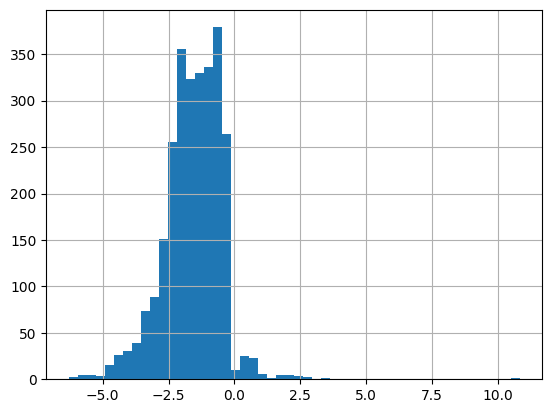

In [ ]:
df_rank_mbio_NE_keep.min_lfc.hist(bins=50)


# Can you provide the same histogram for conventionally essential genes— that is, instead of median FC, highest individual FC?


In [ ]:
df_rank_mbio_ES = df_rank_mbio[df_rank_mbio['mbio Call'] == 'ES'].copy() ## these are all the conventional non-essential genes.

# to find the highest fold-change for any of its essentiality counts in any stage.
list_min_lfc = []
list_gene_id_keep = []

for row in tqdm.tqdm(df_rank_mbio_ES.iterrows()):
  gene_id = row[1]['id'] # each gene.
  df_gene_id = df_filter[df_filter['id'] == gene_id].copy() #find lfc/fdr data for that gene across all stages.

  df_gene_id_sig = df_gene_id[df_gene_id.fdr<=fdr_th].copy() # look only at significant lfc values.

  if df_gene_id_sig.shape[0] > 0:
    min_lfc = df_gene_id_sig.lfc.min()
    list_min_lfc.append(min_lfc)
    list_gene_id_keep.append(gene_id)
  else:
    continue

df_rank_mbio_ES_keep = df_rank_mbio_ES[df_rank_mbio_ES['id'].isin(list_gene_id_keep)].copy()
# Step 2: Convert the 'gene' column to a categorical type with the order defined by genes_list
df_rank_mbio_ES_keep['id'] = pd.Categorical(df_rank_mbio_ES_keep['id'], categories=list_gene_id_keep, ordered=True)

df_rank_mbio_ES_keep['min_lfc'] = list_min_lfc
df_rank_mbio_ES_keep.head(10)

460it [00:11, 38.44it/s]


,id,Counts_1st,Counts_2nd,Counts_3rd,Counts_4th,Total_Counts,Rank,orf,name,essentiality,mbio Call,min_lfc
0,RVBD3596c:clpC1,9,8,11,8,36,0,RVBD3596c,clpC1,Essential,ES,-4.7585
1,RVBD0430:RVBD0430,10,7,10,7,34,1,RVBD0430,RVBD0430,Essential,ES,-5.8126
4,RVBD0732:secY,10,6,9,7,32,4,RVBD0732,secY,Essential,ES,-5.4210
5,RVBD0668:rpoC,8,5,12,7,32,5,RVBD0668,rpoC,Essential,ES,-4.5512
6,RVBD2150c:ftsZ,9,6,11,5,31,6,RVBD2150c,ftsZ,Essential,ES,-5.1428
7,RVBD0014c:pknB,8,8,8,7,31,7,RVBD0014c,pknB,Essential,ES,-3.7709
8,RVBD0482:murB,10,7,7,7,31,8,RVBD0482,murB,Essential,ES,-4.0182
9,RVBD1697:RVBD1697,7,6,11,7,31,9,RVBD1697,RVBD1697,Essential,ES,-5.0233
11,RVBD3808c:glfT2,8,5,10,7,30,11,RVBD3808c,glfT2,Essential,ES,-4.6260
12,RVBD3246c:mtrA,8,6,11,5,30,12,RVBD3246c,mtrA,Essential,ES,-6.1579


<Axes: >

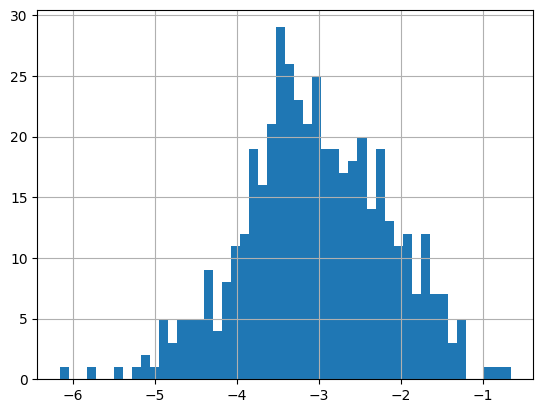

In [ ]:
df_rank_mbio_ES_keep.min_lfc.hist(bins=50)


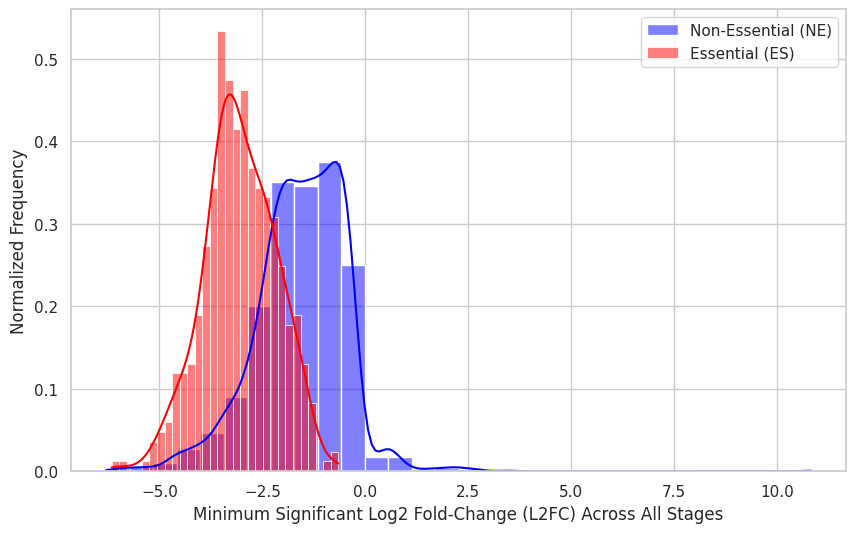

In [ ]:
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plotting histograms with kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(df_rank_mbio_NE_keep.min_lfc, color="blue", kde=True, stat="density", label='Non-Essential (NE)', bins=30, alpha=0.5)
sns.histplot(df_rank_mbio_ES_keep.min_lfc, color="red", kde=True, stat="density", label='Essential (ES)', bins=30, alpha=0.5)

# Adding labels and title
plt.xlabel('Minimum Significant Log2 Fold-Change (L2FC) Across All Stages')
plt.ylabel('Normalized Frequency')
# plt.title('Normalized Distribution of Minimum Log2 Fold Change for NE and ES Genes')
plt.legend()  # Add a legend to distinguish between histograms

fn_path = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/figures/"
fn_fig = os.path.join(fn_path, 'min_lfc_ES_vs_NE.png')
plt.savefig(fn_fig, dpi=300)



# Can you provide excel files for, say, the top 100 essential genes and the top 100 nonessential genes ranked by the maximum log2FC for any comparison pertaining for that gene?

In [ ]:
fn_path = "/content/drive/MyDrive/TheJinichLab/collaborations/Carl_Nathan/data/"
fn_table = os.path.join(fn_path, 'min_lfc_NE_ranked.xlsx')
df_rank_mbio_NE_keep.sort_values(by='min_lfc', ascending=True).head(100).to_excel(fn_table, index = False)

In [ ]:
fn_table = os.path.join(fn_path, 'min_lfc_ES_ranked.xlsx')
df_rank_mbio_ES_keep.sort_values(by='min_lfc', ascending=True).head(100).to_excel(fn_table, index = False)

# If it shows the single highest-magnitude negative fold-change, then there should be no bars on the positive side. Since there are some bars there, should we assume that it actually shows the single highest-magnitude fold change, which in most cases is negative?



In [ ]:
df_rank_mbio_NE_keep.sort_values(by='min_lfc', ascending=False).head(5)

,id,Counts_1st,Counts_2nd,Counts_3rd,Counts_4th,Total_Counts,Rank,orf,name,essentiality,mbio Call,min_lfc
3132,RVBD0583c:lpqN,0,0,0,0,0,3132,RVBD0583c,lpqN,NonEssential,NE,10.8170
4006,RVBD1322A:RVBD1322A,0,0,0,0,0,4006,RVBD1322A,RVBD1322A,NonEssential,NE,3.4679
2931,RVBD0659c:RVBD0659c,0,0,0,0,0,2931,RVBD0659c,RVBD0659c,NonEssential,NE,2.7637
3942,RVBD0546c:RVBD0546c,0,0,0,0,0,3942,RVBD0546c,RVBD0546c,NonEssential,NE,2.6702
3429,RVBD0293c:RVBD0293c,0,0,0,0,0,3429,RVBD0293c,RVBD0293c,NonEssential,NE,2.5029


In [ ]:
gene_id = "RVBD1322A:RVBD1322A" # each gene
df_gene_id = df_filter[df_filter['id'] == gene_id].copy() #find lfc/fdr data for that gene across all stages.
df_gene_id_sig = df_gene_id[df_gene_id.fdr<=fdr_th].copy() # look only at significant lfc values.

In [ ]:
df_gene_id.sort_values(by='fdr', ascending=True).head()[['id', 'lfc', 'fdr', 'effect']]

,id,lfc,fdr,effect
38798,RVBD1322A:RVBD1322A,3.46790,0.004846,Positive
127329,RVBD1322A:RVBD1322A,1.10580,0.052368,Positive
199036,RVBD1322A:RVBD1322A,1.28770,0.059301,Positive
77906,RVBD1322A:RVBD1322A,-0.21648,0.095439,Negative
95807,RVBD1322A:RVBD1322A,-0.49782,0.202347,Negative


# ​Next, I assume that each bar collects some number of genes with a fold change in a bin of a given range. What is the range for conventionally essentials and what is the range for conventionally nonessentials? Why are the ranges different? Put another way, why are the blue bars thicker than the red bars?


In [ ]:
df_rank_mbio_NE_keep.min_lfc.describe()

count    2765.000000
mean       -1.573562
std         1.102168
min        -6.291700
25%        -2.192800
50%        -1.491700
75%        -0.788920
max        10.817000
Name: min_lfc, dtype: float64

In [ ]:
df_rank_mbio_ES_keep.min_lfc.describe()

count    460.000000
mean      -3.046689
std        0.879793
min       -6.157900
25%       -3.587725
50%       -3.061200
75%       -2.440300
max       -0.657330
Name: min_lfc, dtype: float64